# RL Lab 03 - Part 1- Monte Carlo predicition on BlackJack

## 1. Monte Carlo prediction

In these exercises, we will explore the **the Monte Carlo prediction algorithhm**. <br>

The algorithm is shown on the [course slide deck.](https://centralesupelec.edunao.com/pluginfile.php/221332/mod_resource/content/1/2122-RL-Lecture04.pdf)<br>
The algorithm will be tested on Blackjack. <br>

### 1.1 Setup

In [1]:
!pip install gym
# !pip install plotting
!wget -nc https://raw.githubusercontent.com/lcharlin/80-629/master/week13-RL/blackjack.py
!wget -nc https://raw.githubusercontent.com/lcharlin/80-629/master/week13-RL/plotting.py

--2022-02-23 22:05:35--  https://raw.githubusercontent.com/lcharlin/80-629/master/week13-RL/blackjack.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4251 (4.2K) [text/plain]
Saving to: ‘blackjack.py’

blackjack.py        100%[===================>]   4.15K  --.-KB/s    in 0s      

2022-02-23 22:05:35 (31.1 MB/s) - ‘blackjack.py’ saved [4251/4251]

--2022-02-23 22:05:35--  https://raw.githubusercontent.com/lcharlin/80-629/master/week13-RL/plotting.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3457 (3.4K) [text/plain]
Savin

In [2]:
# imports
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

### BlackJack Rules

First, we define the Blackjack environment:

<ul>
<li />Black Jack is a card game where a player must obtain cards such that their sum is as close to 21 without exceeding it.
<li />Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and it's called 'usable' at 11.
<li />In our example below, the player plays against a dealer. The dealer has a fixed policy of always asking for an additional card until the sum of their cards is above 17. 
<li /> Stationarity: This game is placed with an infinite deck (or with replacement).
</ul>

Game Process:
<ol>
<li /> The game starts with each (player and dealer) having one face up and one
    face down card.
<li /> The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
<li />If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
</ol>
<img src="https://youngho92.github.io/images/RL/procedure.png" width="800">

In [4]:
env = BlackjackEnv()

### 1.2 Monte Carlo prediction

Recall that the Monte Carlo prediction algorithm provides a method for evaluating a given policy ($\pi$), that is obtain its value for each state $V(s)\;\;\forall s \in S$. 

It is similar to the policy evaluation step used in policy iteration for MDPs. The main difference is that **here we do not know the transition probabilities** and so we will have an agent that tries out the policy in the environment and, episode by episode, calculates the value function of the policy.

You need to write a function that evaluates the values of each states given a policy. <br>




In [8]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0, plot_every=False):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action) # YOUR CODE HERE #
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])

        for state in states_in_episode:
            # Find the first occurence of the state in the episode
            first_occurence_idx = next(i for i, x in enumerate(episode) if x[0]==state) # YOUR CODE HERE #
            # Sum up all rewards since the first occurance
            # YOUR CODE HERE #
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G # YOUR CODE HERE #
            returns_count[state] += 1  # YOUR CODE HERE #
            V[state] = returns_sum[state]/returns_count[state] # YOUR CODE HERE #
            
        if plot_every and i_episode % plot_every ==0:
            plotting.plot_value_function(V, title=f"{i_episode} Steps")

    return V    

Now, we will define a simple policy which we will evaluate. <br>
Specifically, **the policy hits except when the sum of the card is 20 or 21.**

In [9]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

We now evaluate the policy for 20k iterations. <br>


Episode 20000/20000.

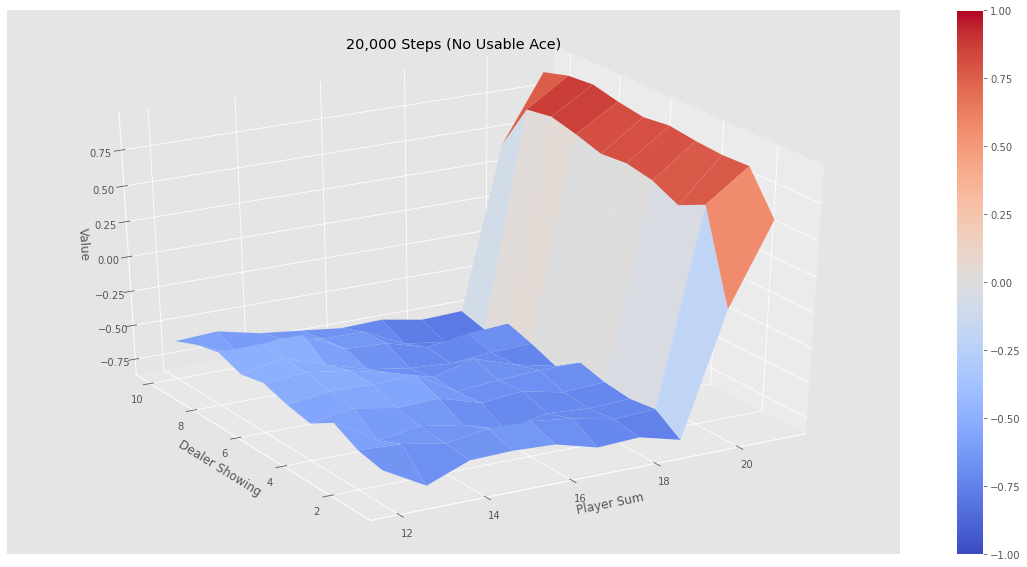

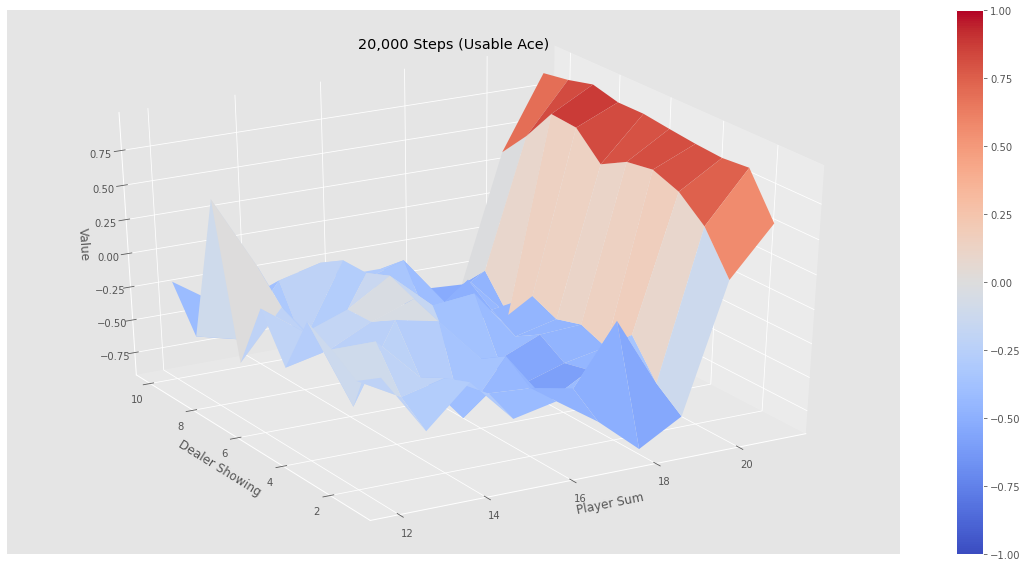

In [10]:
V_20k = mc_prediction(sample_policy, env, num_episodes=20000)
plotting.plot_value_function(V_20k, title="20,000 Steps")

## Question
Can you interpret the graph ?

Answer: 

When with Ace, there are more variance in the values earned.

### 1.3 Monte Carlo prediction on multiple episodes

In this part we will analyze the effect of the number of episodes (num_episodes) on the learned value function.

In [11]:
V_20k = mc_prediction(sample_policy, env, num_episodes=200000, plot_every=10000)

Output hidden; open in https://colab.research.google.com to view.

## Question 
What's the effect of the number of episodes (num_episodes) on the learned value function ?

Answer:

As the number of episodes sampled increases, the variance of values when a player has a useable ace decreases before getting to 20/21. This indicates that the agent has been able to more precisely learn when to hit even with a useable ace.

### Do not forget Part 2 of the Lab, refer to the second notebook